In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import networkx as nx
import ast
from pathlib import Path

Mounted at /content/drive


In [ ]:
BASE_DIR = Path("/content/drive/MyDrive")
pair_df = pd.read_csv(BASE_DIR / "pair_stats_per_article_with_date.csv")

print("CSV loaded!")
print("Shape:", pair_df.shape)
print("Columns:", list(pair_df.columns))
print("\nFirst few rows:")
display(pair_df.head())

CSV loaded!
Shape: (55583, 7)
Columns: ['SQLDATE', 'entity_1', 'entity_2', 'co_occurrence', 'sentiments', 'avg_sentiment_article', 'std_sentiment_article']

First few rows:


SQLDATE                    entity_1                    entity_2  \
0  2025-07-17               Puerto Rico’s  New Fortress Energy Inc.'s   
1  2025-07-25            European Union’s                    slovakia   
2  2025-07-31                       tesla                      the US   
3  2025-07-14  New Fortress Energy Inc.'s               Puerto Rico’s   
4  2025-05-06                    Parkland                   Sunoco LP   

   co_occurrence                                         sentiments  \
0              7          [-0.743, 0.2732, -0.1531, 0.7579, 0.8176]   
1              8  [0.5562, 0.6369, -0.2732, -0.891, 0.5423, -0.3...   
2             10                             [0.2263, -0.3597, 0.0]   
3              7          [-0.743, 0.2732, -0.1531, 0.7579, 0.8176]   
4              7     [0.3595, 0.3182, 0.0, 0.2732, 0.296, 0.0, 0.0]   

   avg_sentiment_article  std_sentiment_article  
0               0.190520               0.585067  
1               0.036143               0.530460  
2              -0.044467               0.241291  
3               0.190520               0.585067  
4               0.178129               0.156131

In [ ]:
print("Date column sample:", pair_df['SQLDATE'].iloc[0])
print("Sentiments column sample:", pair_df['sentiments'].iloc[0])
print("Type of sentiments:", type(pair_df['sentiments'].iloc[0]))

Date column sample: 2025-07-17
Sentiments column sample: [-0.743, 0.2732, -0.1531, 0.7579, 0.8176]
Type of sentiments: <class 'str'>


In [ ]:
Convert sentiments from string to list (if needed)
if isinstance(pair_df['sentiments'].iloc[0], str):
    pair_df['sentiments'] = pair_df['sentiments'].apply(ast.literal_eval)
    print("Converted sentiments from string to list")

Converted sentiments from string to list


In [ ]:
# Convert SQLDATE to datetime
pair_df['SQLDATE'] = pd.to_datetime(pair_df['SQLDATE'])
print("Converted SQLDATE to datetime")

Converted SQLDATE to datetime


In [ ]:

# Check unique days
unique_days = sorted(pair_df['SQLDATE'].unique())
print(f"\nTotal unique days: {len(unique_days)}")
print(f"First 5 days: {unique_days[:5]}")


Total unique days: 267
First 5 days: [Timestamp('2025-01-01 00:00:00'), Timestamp('2025-01-02 00:00:00'), Timestamp('2025-01-03 00:00:00'), Timestamp('2025-01-04 00:00:00'), Timestamp('2025-01-05 00:00:00')]


In [ ]:

Build Cumulative Graphs, just a test - first 5 days only
TEST_DAYS = 5
daily_entity_pair_dict_list = []
entity_pair_dict = {}

# Get only first TEST_DAYS days
test_days = unique_days[:TEST_DAYS]
print(f"\nBuilding graphs for {len(test_days)} days...")

for day_idx, day in enumerate(test_days):
    # Get rows for this day
    day_rows = pair_df[pair_df['SQLDATE'] == day]

    for i, r in day_rows.iterrows():
        e1 = r['entity_1']
        e2 = r['entity_2']

        # Sort entities to create consistent pair key
        e = tuple(sorted([e1, e2]))

        # Initialize if new pair
        if e not in entity_pair_dict:
            entity_pair_dict[e] = {
                'co_occurrence': 0,
                'sentiments': []
            }

        # Add this row's data cumulatively
        entity_pair_dict[e]['co_occurrence'] += r['co_occurrence']
        entity_pair_dict[e]['sentiments'] += r['sentiments']

    # Save snapshot of cumulative dict for this day
    daily_entity_pair_dict_list.append({
        'day': day,
        'entity_pair_dict': {k: v.copy() for k, v in entity_pair_dict.items()}
    })

    # Deep copy the sentiments lists
    for k in daily_entity_pair_dict_list[-1]['entity_pair_dict']:
        daily_entity_pair_dict_list[-1]['entity_pair_dict'][k]['sentiments'] = \
            entity_pair_dict[k]['sentiments'].copy()

    print(f"Day {day_idx + 1}: {day.date()} - {len(entity_pair_dict)} cumulative pairs")

print("\nCumulative pair dicts built!")


Building graphs for 5 days...
Day 1: 2025-01-01 - 28 cumulative pairs
Day 2: 2025-01-02 - 158 cumulative pairs
Day 3: 2025-01-03 - 208 cumulative pairs
Day 4: 2025-01-04 - 228 cumulative pairs
Day 5: 2025-01-05 - 259 cumulative pairs

Cumulative pair dicts built!


In [ ]:

# build NetworkX Graphs with Filtering
daily_graphs = []

for day_data in daily_entity_pair_dict_list:
    day = day_data['day']
    day_entity_pair_dict = day_data['entity_pair_dict']

    G = nx.Graph()

    # Get co-occurrences for percentile calculation
    co_occurrences = [d['co_occurrence'] for d in day_entity_pair_dict.values()]

    if len(co_occurrences) == 0:
        daily_graphs.append({'day': day, 'graph': G})
        continue

    # Threshold: 95th percentile
    n_95 = max(5, np.percentile(co_occurrences, 95))

    # Add edges for pairs above threshold
    for entity_pair, entity_pair_stats in day_entity_pair_dict.items():
        if entity_pair_stats['co_occurrence'] <= n_95:
            continue

        e1, e2 = entity_pair
        sentiments = entity_pair_stats['sentiments']

        G.add_edge(
            e1,
            e2,
            co_occurrence=entity_pair_stats['co_occurrence'],
            sentiment_mean=np.mean(sentiments) if sentiments else 0,
            sentiment_std=np.std(sentiments) if len(sentiments) > 1 else 0
        )

    daily_graphs.append({'day': day, 'graph': G})
    print(f"{day.date()}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges (threshold: {n_95:.1f})")

print("\nGraphs built!")

2025-01-01: 4 nodes, 2 edges (threshold: 25.9)
2025-01-02: 6 nodes, 8 edges (threshold: 63.5)
2025-01-03: 11 nodes, 11 edges (threshold: 61.6)
2025-01-04: 12 nodes, 12 edges (threshold: 61.6)
2025-01-05: 13 nodes, 13 edges (threshold: 59.1)

Graphs built!


In [ ]:
# inspect one graph
if daily_graphs:
    last_graph = daily_graphs[-1]['graph']
    print(f"\nLast graph ({daily_graphs[-1]['day'].date()}):")
    print(f"  Nodes: {last_graph.number_of_nodes()}")
    print(f"  Edges: {last_graph.number_of_edges()}")

    # Show a few edges with their attributes
    print("\n  Sample edges:")
    for i, (u, v, data) in enumerate(last_graph.edges(data=True)):
        if i >= 3:
            break
        print(f"    {u} -- {v}")
        print(f"      co_occurrence: {data['co_occurrence']}")
        print(f"      sentiment_mean: {data['sentiment_mean']:.3f}")
        print(f"      sentiment_std: {data['sentiment_std']:.3f}")


Last graph (2025-01-05):
  Nodes: 13
  Edges: 13

  Sample edges:
    Ukraine -- the Russia/Ukraine
      co_occurrence: 103
      sentiment_mean: -0.108
      sentiment_std: 0.536
    tesla -- the US
      co_occurrence: 60
      sentiment_mean: 0.166
      sentiment_std: 0.359
    tesla -- Musk
      co_occurrence: 70
      sentiment_mean: 0.196
      sentiment_std: 0.478


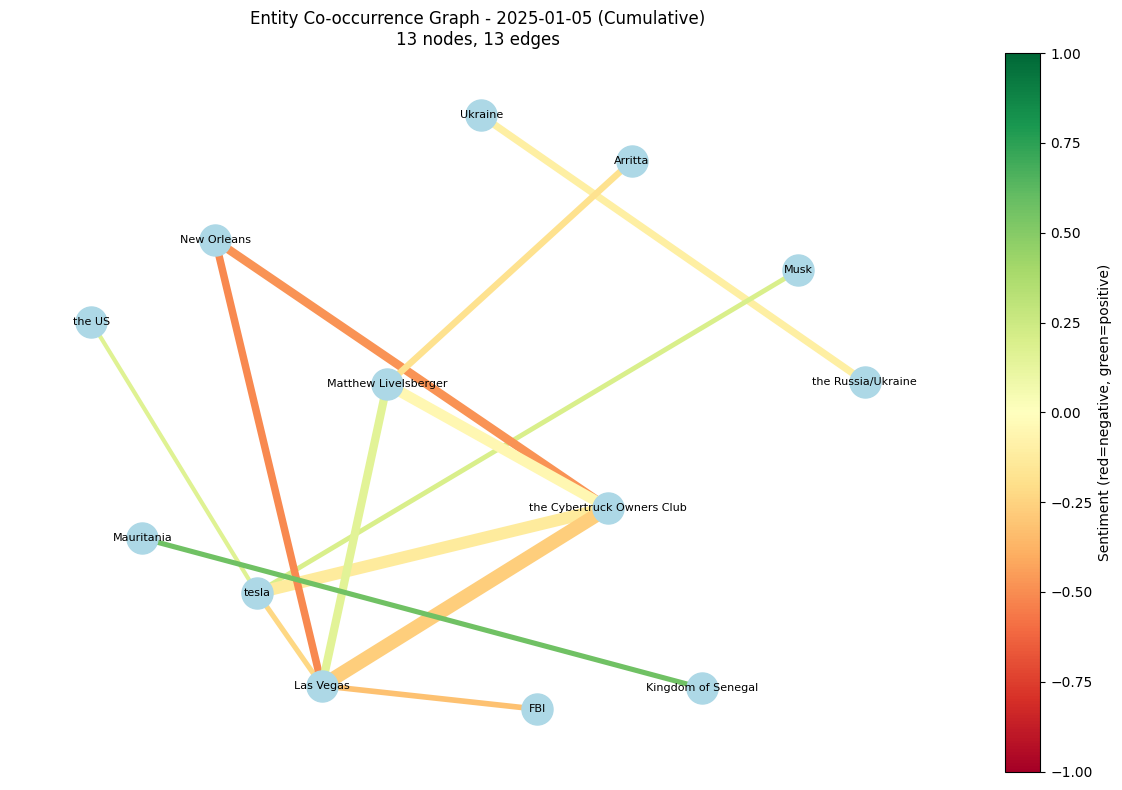

In [ ]:
import matplotlib.pyplot as plt

# Pick which day's graph to plot (0 = first day, -1 = last day)
graph_to_plot = daily_graphs[-1]  # Last day
G = graph_to_plot['graph']
day = graph_to_plot['day']

plt.figure(figsize=(12, 8))

# Create layout
pos = nx.spring_layout(G, seed=42, k=2)

# Get edge weights for thickness
edge_weights = [G[u][v]['co_occurrence'] / 20 for u, v in G.edges()]

# Get edge colors based on sentiment (red = negative, green = positive)
edge_colors = [G[u][v]['sentiment_mean'] for u, v in G.edges()]

# Draw the graph
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=8)
edges = nx.draw_networkx_edges(
    G, pos,
    width=edge_weights,
    edge_color=edge_colors,
    edge_cmap=plt.cm.RdYlGn,  # Red to Green colormap
    edge_vmin=-1,
    edge_vmax=1
)

# Add colorbar
plt.colorbar(edges, label='Sentiment (red=negative, green=positive)')

plt.title(f"Entity Co-occurrence Graph - {day.date()} (Cumulative)\n{G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Build all cumulative graphs
import time

# Reset the cumulative dict
daily_entity_pair_dict_list = []
entity_pair_dict = {}

print(f"Building graphs for ALL {len(unique_days)} days...")
print("This may take 10-20 minutes...\n")

start_time = time.time()

for day_idx, day in enumerate(unique_days):
    # Get rows for this day
    day_rows = pair_df[pair_df['SQLDATE'] == day]

    for i, r in day_rows.iterrows():
        e1 = r['entity_1']
        e2 = r['entity_2']

        # Sort entities to create consistent pair key
        e = tuple(sorted([e1, e2]))

        # Initialize if new pair
        if e not in entity_pair_dict:
            entity_pair_dict[e] = {
                'co_occurrence': 0,
                'sentiments': []
            }

        # Add this row's data cumulatively
        entity_pair_dict[e]['co_occurrence'] += r['co_occurrence']
        entity_pair_dict[e]['sentiments'] += r['sentiments']

    # Save snapshot of cumulative dict for this day
    daily_entity_pair_dict_list.append({
        'day': day,
        'entity_pair_dict': {k: {'co_occurrence': v['co_occurrence'], 'sentiments': v['sentiments'].copy()}
                            for k, v in entity_pair_dict.items()}
    })

    # Progress update every 20 days
    if (day_idx + 1) % 20 == 0:
        elapsed = time.time() - start_time
        print(f"Day {day_idx + 1}/{len(unique_days)}: {day.date()} - {len(entity_pair_dict)} cumulative pairs ({elapsed:.1f}s)")

total_time = time.time() - start_time
print(f"\nCumulative pair dicts built in {total_time:.1f} seconds!")

# build NetworkX Graphs with Filtering
print("\nBuilding NetworkX graphs...")

daily_graphs = []

for day_idx, day_data in enumerate(daily_entity_pair_dict_list):
    day = day_data['day']
    day_entity_pair_dict = day_data['entity_pair_dict']

    G = nx.Graph()

    # Get co-occurrences for percentile calculation
    co_occurrences = [d['co_occurrence'] for d in day_entity_pair_dict.values()]

    if len(co_occurrences) == 0:
        daily_graphs.append({'day': day, 'graph': G})
        continue

    # Threshold: 95th percentile, minimum 5
    n_95 = max(5, np.percentile(co_occurrences, 95))

    # Add edges for pairs above threshold
    edges_added = 0
    for entity_pair, entity_pair_stats in day_entity_pair_dict.items():
        if entity_pair_stats['co_occurrence'] <= n_95:
            continue

        e1, e2 = entity_pair
        sentiments = entity_pair_stats['sentiments']

        G.add_edge(
            e1,
            e2,
            co_occurrence=entity_pair_stats['co_occurrence'],
            sentiment_mean=np.mean(sentiments) if sentiments else 0,
            sentiment_std=np.std(sentiments) if len(sentiments) > 1 else 0
        )
        edges_added += 1

    daily_graphs.append({'day': day, 'graph': G})

    # Progress update every 50 days
    if (day_idx + 1) % 50 == 0:
        print(f"Day {day_idx + 1}/{len(unique_days)}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

print(f"\nAll {len(daily_graphs)} graphs built!")

# Save to Drive
import pickle

output_path = BASE_DIR / "daily_cumulative_graphs.pkl"

with open(output_path, 'wb') as f:
    pickle.dump(daily_graphs, f)

print(f"Saved {len(daily_graphs)} graphs to:")
print(output_path)

# summary of graphs
print(f"\nFirst graph ({daily_graphs[0]['day'].date()}): {daily_graphs[0]['graph'].number_of_nodes()} nodes, {daily_graphs[0]['graph'].number_of_edges()} edges")
print(f"Last graph ({daily_graphs[-1]['day'].date()}): {daily_graphs[-1]['graph'].number_of_nodes()} nodes, {daily_graphs[-1]['graph'].number_of_edges()} edges")

Building graphs for ALL 267 days...
This may take 10-20 minutes...

Day 20/267: 2025-01-20 - 2171 cumulative pairs (0.5s)
Day 40/267: 2025-02-09 - 3025 cumulative pairs (1.0s)
Day 60/267: 2025-03-01 - 3916 cumulative pairs (1.6s)
Day 80/267: 2025-03-21 - 4926 cumulative pairs (2.5s)
Day 100/267: 2025-04-10 - 5885 cumulative pairs (3.5s)
Day 120/267: 2025-04-30 - 6549 cumulative pairs (4.5s)
Day 140/267: 2025-05-20 - 7122 cumulative pairs (6.1s)
Day 160/267: 2025-06-09 - 7746 cumulative pairs (9.0s)
Day 180/267: 2025-07-13 - 8217 cumulative pairs (11.3s)
Day 200/267: 2025-08-02 - 9301 cumulative pairs (15.2s)
Day 220/267: 2025-08-22 - 9733 cumulative pairs (16.6s)
Day 240/267: 2025-09-11 - 10277 cumulative pairs (19.4s)
Day 260/267: 2025-10-01 - 10877 cumulative pairs (20.9s)

Cumulative pair dicts built in 21.5 seconds!

Building NetworkX graphs...
Day 50/267: 71 nodes, 179 edges
Day 100/267: 100 nodes, 293 edges
Day 150/267: 107 nodes, 372 edges
Day 200/267: 99 nodes, 465 edges
Day 25

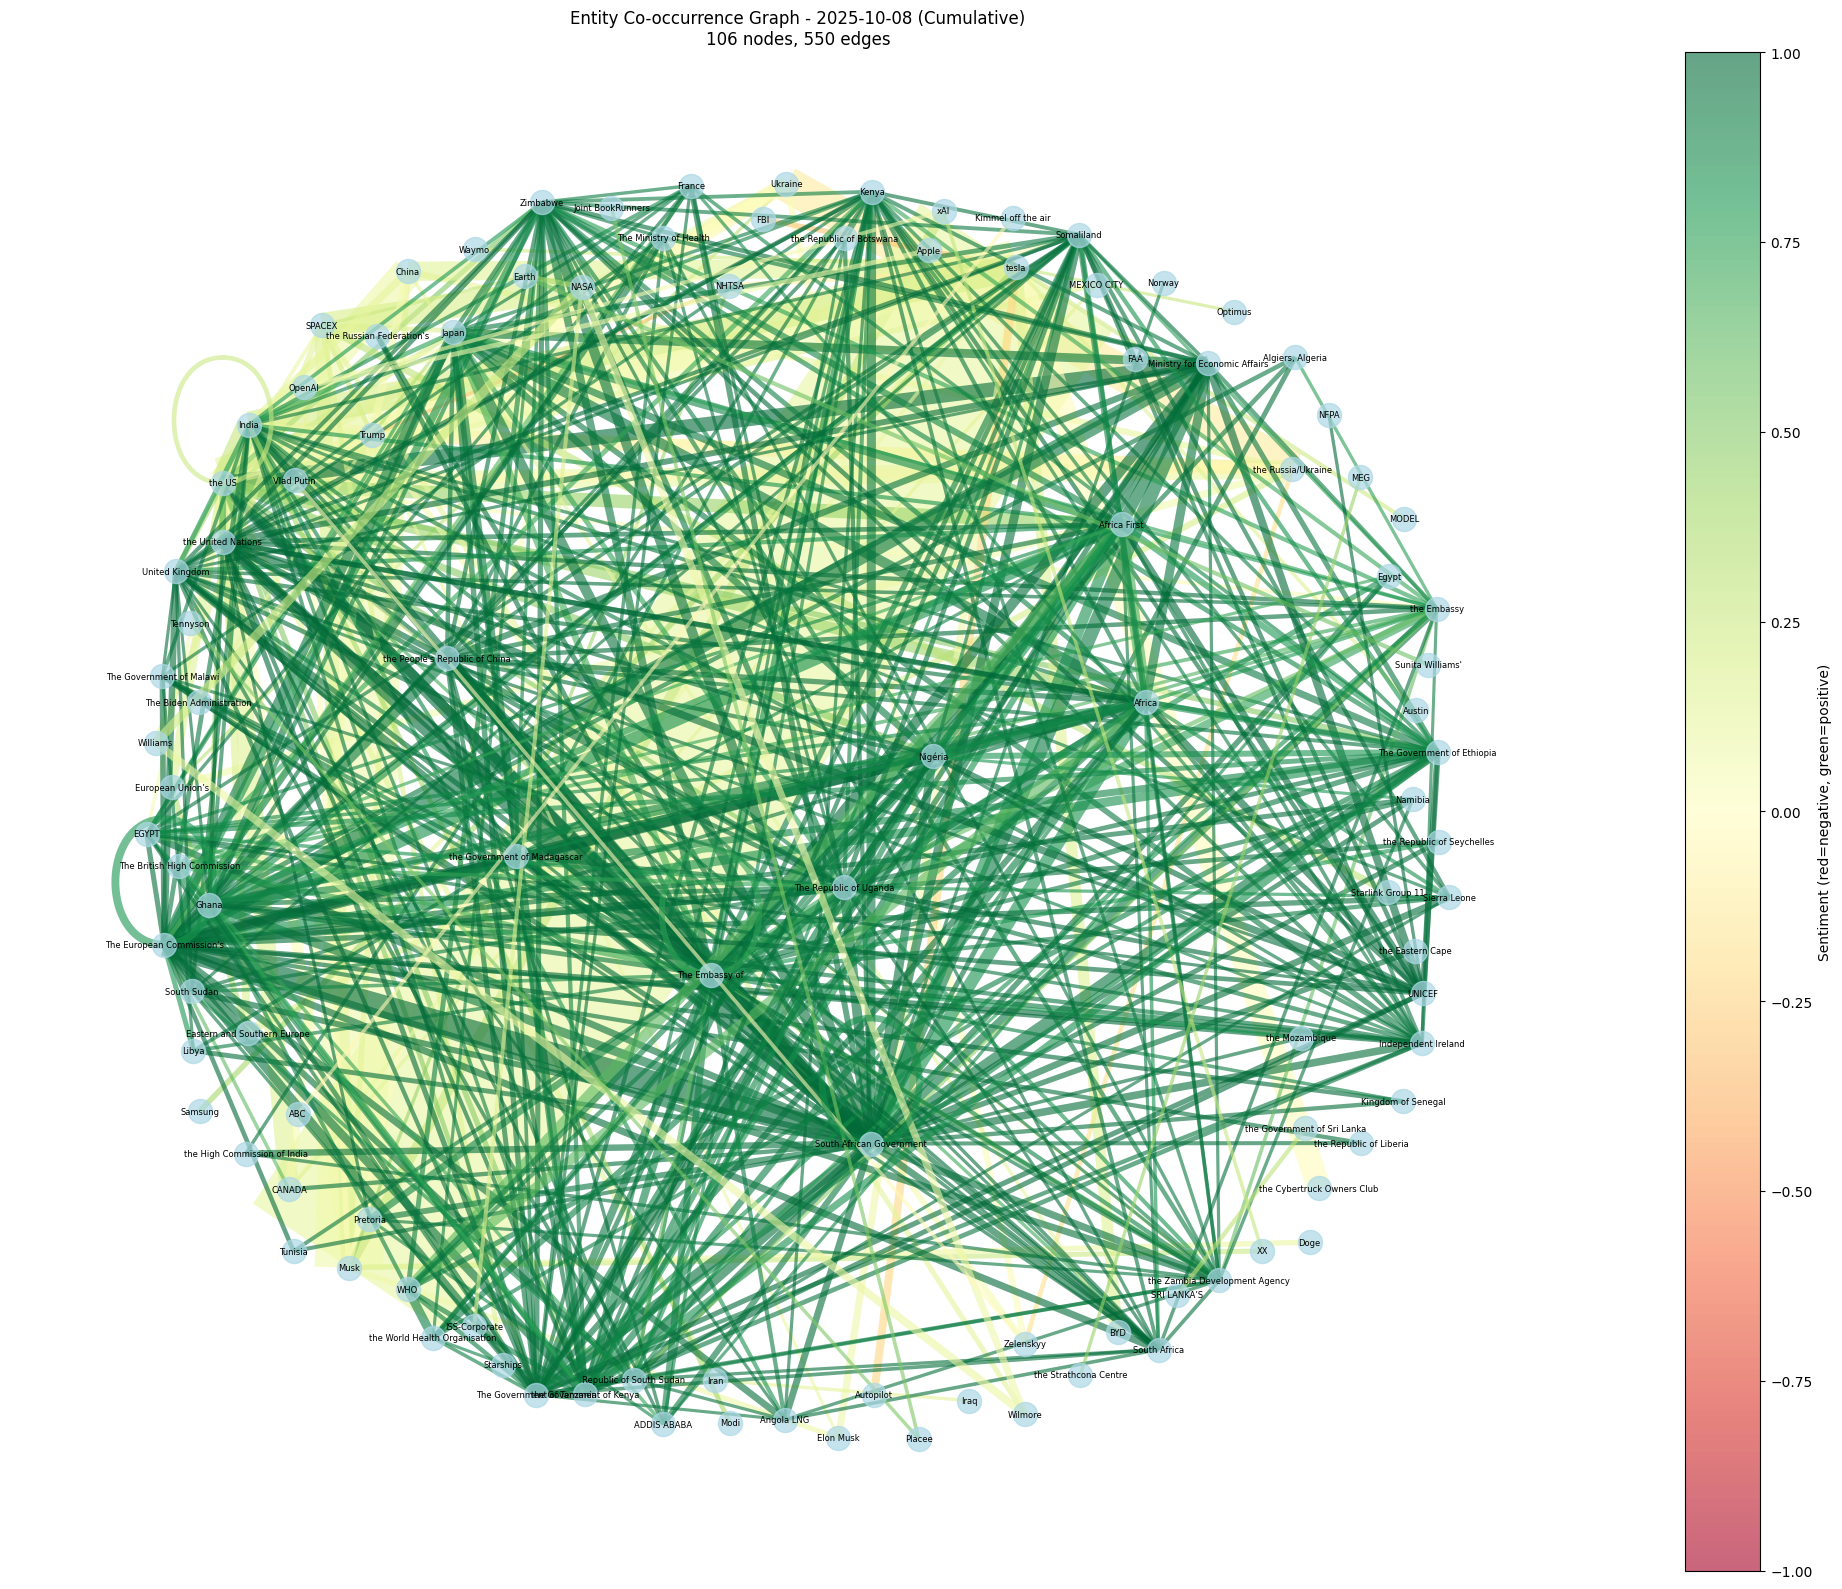

In [ ]:
# plot Last Day Graph
import matplotlib.pyplot as plt

# Get the last graph
graph_to_plot = daily_graphs[-1]
G = graph_to_plot['graph']
day = graph_to_plot['day']

plt.figure(figsize=(20, 16))

# Create layout - increase k for more spacing
pos = nx.spring_layout(G, seed=42, k=3, iterations=50)

# Get edge weights for thickness (scale down for visibility)
edge_weights = [G[u][v]['co_occurrence'] / 100 for u, v in G.edges()]

# Get edge colors based on sentiment
edge_colors = [G[u][v]['sentiment_mean'] for u, v in G.edges()]

# Draw the graph
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue', alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=6)
edges = nx.draw_networkx_edges(
    G, pos,
    width=edge_weights,
    edge_color=edge_colors,
    edge_cmap=plt.cm.RdYlGn,
    edge_vmin=-1,
    edge_vmax=1,
    alpha=0.6
)

# Add colorbar
plt.colorbar(edges, label='Sentiment (red=negative, green=positive)')

plt.title(f"Entity Co-occurrence Graph - {day.date()} (Cumulative)\n{G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
plt.axis('off')
plt.tight_layout()
plt.show()

Found Tesla node: 'tesla'


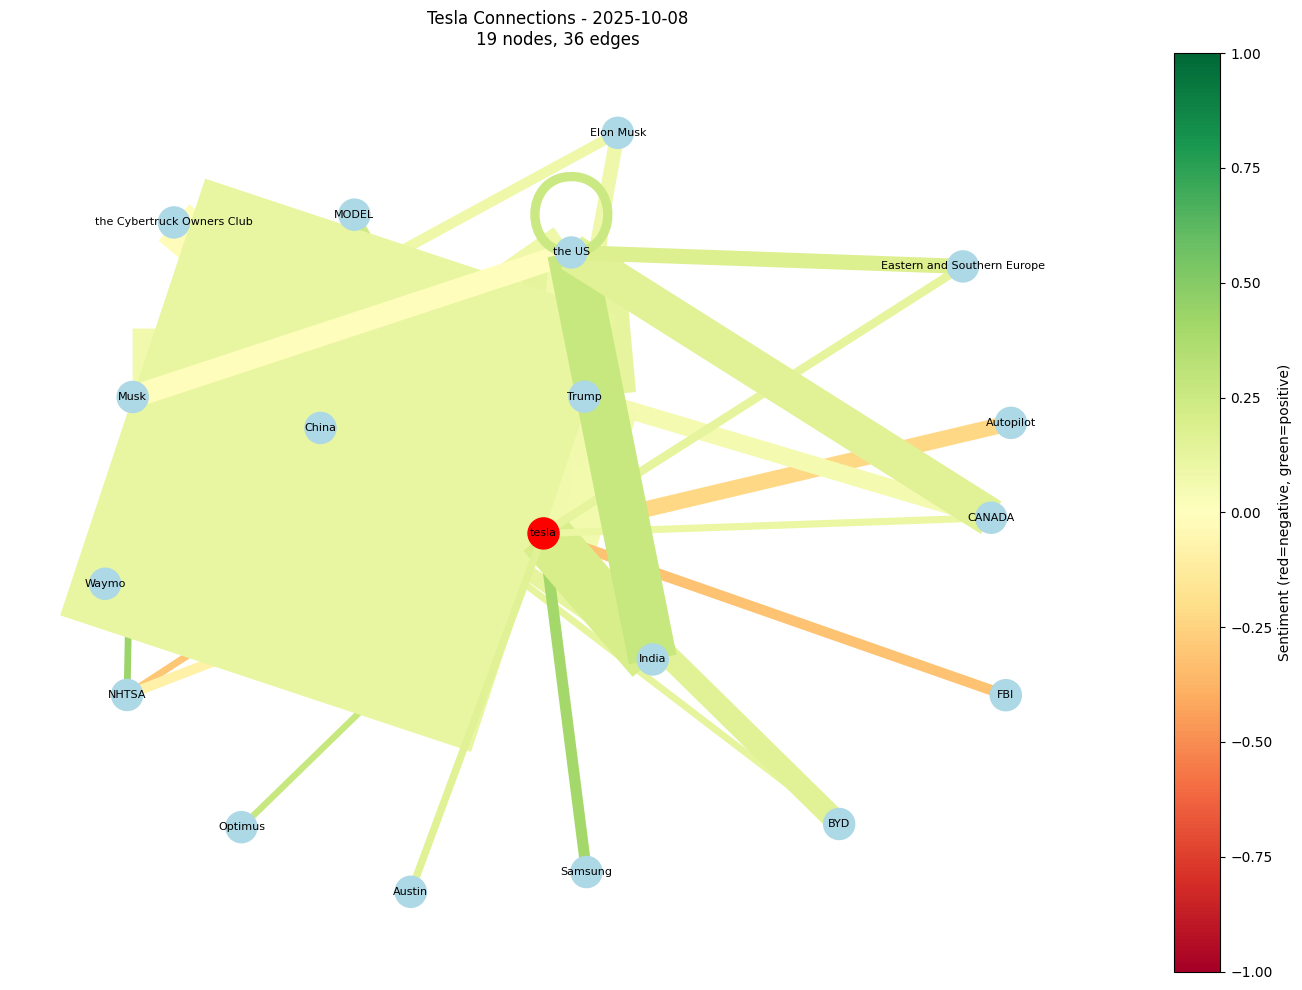

In [ ]:
# plot Tesla's connections only and also last day
import matplotlib.pyplot as plt

# Get the last graph
G = daily_graphs[-1]['graph']
day = daily_graphs[-1]['day']

# Find tesla node
tesla_node = None
for node in G.nodes():
    if 'tesla' in node.lower():
        tesla_node = node
        print(f"Found Tesla node: '{tesla_node}'")
        break

if tesla_node:
    # Get subgraph with only tesla and its neighbors
    tesla_neighbors = list(G.neighbors(tesla_node))
    tesla_subgraph_nodes = [tesla_node] + tesla_neighbors
    G_tesla = G.subgraph(tesla_subgraph_nodes)

    plt.figure(figsize=(14, 10))

    pos = nx.spring_layout(G_tesla, seed=42, k=2)

    edge_weights = [G_tesla[u][v]['co_occurrence'] / 50 for u, v in G_tesla.edges()]
    edge_colors = [G_tesla[u][v]['sentiment_mean'] for u, v in G_tesla.edges()]

    # Highlight tesla node
    node_colors = ['red' if n == tesla_node else 'lightblue' for n in G_tesla.nodes()]

    nx.draw_networkx_nodes(G_tesla, pos, node_size=500, node_color=node_colors)
    nx.draw_networkx_labels(G_tesla, pos, font_size=8)
    edges = nx.draw_networkx_edges(
        G_tesla, pos,
        width=edge_weights,
        edge_color=edge_colors,
        edge_cmap=plt.cm.RdYlGn,
        edge_vmin=-1,
        edge_vmax=1
    )

    plt.colorbar(edges, label='Sentiment (red=negative, green=positive)')
    plt.title(f"Tesla Connections - {day.date()}\n{G_tesla.number_of_nodes()} nodes, {G_tesla.number_of_edges()} edges")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Tesla node not found in graph")



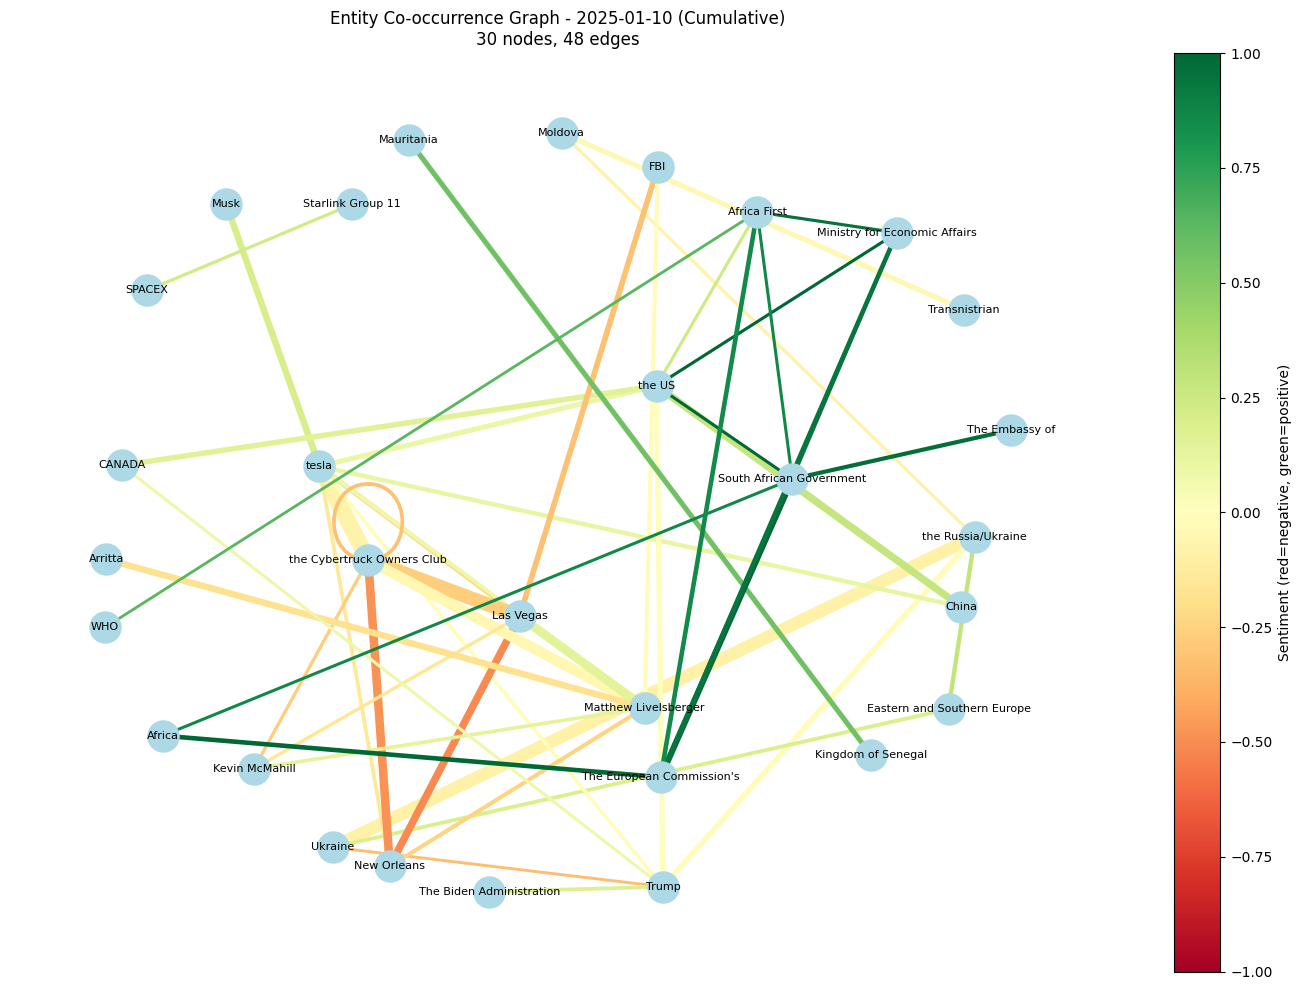

In [ ]:
# Plot Day 10
G_day10 = daily_graphs[9]['graph']  # Index 9 = Day 10
day10 = daily_graphs[9]['day']

plt.figure(figsize=(14, 10))

pos = nx.spring_layout(G_day10, seed=42, k=2)

edge_weights = [G_day10[u][v]['co_occurrence'] / 20 for u, v in G_day10.edges()]
edge_colors = [G_day10[u][v]['sentiment_mean'] for u, v in G_day10.edges()]

nx.draw_networkx_nodes(G_day10, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_labels(G_day10, pos, font_size=8)
edges = nx.draw_networkx_edges(
    G_day10, pos,
    width=edge_weights,
    edge_color=edge_colors,
    edge_cmap=plt.cm.RdYlGn,
    edge_vmin=-1,
    edge_vmax=1
)

plt.colorbar(edges, label='Sentiment (red=negative, green=positive)')
plt.title(f"Entity Co-occurrence Graph - {day10.date()} (Cumulative)\n{G_day10.number_of_nodes()} nodes, {G_day10.number_of_edges()} edges")
plt.axis('off')
plt.tight_layout()
plt.show()

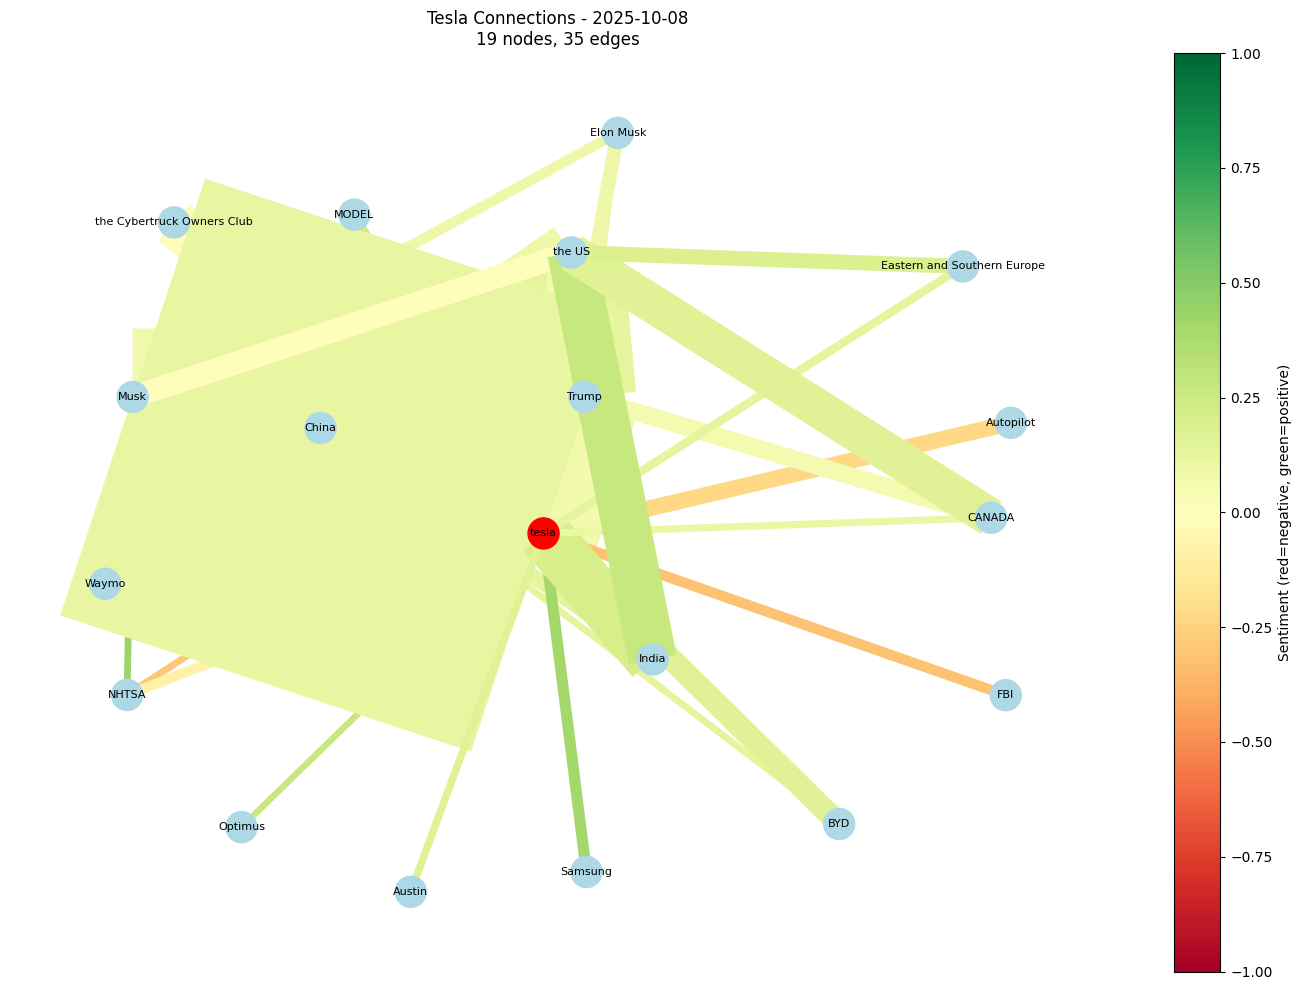

In [ ]:
# tesla Connections - Clean Version
G = daily_graphs[-1]['graph']
day = daily_graphs[-1]['day']

tesla_node = 'tesla'
tesla_neighbors = list(G.neighbors(tesla_node))
tesla_subgraph_nodes = [tesla_node] + tesla_neighbors
G_tesla = G.subgraph(tesla_subgraph_nodes).copy()

# Remove self-loops
G_tesla.remove_edges_from(nx.selfloop_edges(G_tesla))

plt.figure(figsize=(14, 10))

pos = nx.spring_layout(G_tesla, seed=42, k=2)

edge_weights = [G_tesla[u][v]['co_occurrence'] / 50 for u, v in G_tesla.edges()]
edge_colors = [G_tesla[u][v]['sentiment_mean'] for u, v in G_tesla.edges()]

node_colors = ['red' if n == tesla_node else 'lightblue' for n in G_tesla.nodes()]

nx.draw_networkx_nodes(G_tesla, pos, node_size=500, node_color=node_colors)
nx.draw_networkx_labels(G_tesla, pos, font_size=8)
edges = nx.draw_networkx_edges(
    G_tesla, pos,
    width=edge_weights,
    edge_color=edge_colors,
    edge_cmap=plt.cm.RdYlGn,
    edge_vmin=-1,
    edge_vmax=1,
    alpha=1.0  # No transparency
)

plt.colorbar(edges, label='Sentiment (red=negative, green=positive)')
plt.title(f"Tesla Connections - {day.date()}\n{G_tesla.number_of_nodes()} nodes, {G_tesla.number_of_edges()} edges")
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
print(list(daily_graphs[-1]['graph'].nodes())[:50])

['Ukraine', 'the Russia/Ukraine', 'Musk', 'the US', 'tesla', 'SPACEX', 'the Cybertruck Owners Club', 'CANADA', 'Trump', 'Iran', 'Iraq', 'Eastern and Southern Europe', 'FBI', 'The Biden Administration', 'Elon Musk', 'BYD', 'China', 'MODEL', 'Starships', 'Starlink Group 11', 'European Union’s', 'India', 'Japan', 'NHTSA', 'South African Government', 'the Embassy', 'Algiers, Algeria', 'Kenya', 'the High Commission of India', "The European Commission's", 'The Embassy of', 'the Eastern Cape', "the People's Republic of China", "the Russian Federation's", 'Zimbabwe', 'the Zambia Development Agency', 'United Kingdom', 'Ministry for Economic Affairs', 'South Africa', 'Angola LNG', 'Egypt', 'ADDIS ABABA', 'Pretoria', 'Africa First', 'the Republic of Seychelles', 'the United Nations', 'Africa', 'Namibia', 'the Mozambique', 'Tunisia']


In [ ]:
# extract Features from Graphs
import numpy as np
import pandas as pd

# Define nodes of interest
nodes_of_interest = ['tesla', 'Musk', 'SPACEX', 'the Cybertruck Owners Club']

# Function from professor (Image 4) - slightly modified
def calculate_node_edge_sentiment(G, nodes_of_interest):
    all_edge_sentiments_mean = []
    all_edge_sentiments_std = []
    all_co_occurrences = []

    for node in nodes_of_interest:
        if node in G:
            for neighbor, edge_data in G[node].items():
                if 'sentiment_mean' in edge_data:
                    all_edge_sentiments_mean.append(edge_data['sentiment_mean'])
                if 'sentiment_std' in edge_data:
                    all_edge_sentiments_std.append(edge_data['sentiment_std'])
                if 'co_occurrence' in edge_data:
                    all_co_occurrences.append(edge_data['co_occurrence'])

    return all_edge_sentiments_mean, all_edge_sentiments_std, all_co_occurrences

# Extract features for each day
feature_records = []

for day_data in daily_graphs:
    day = day_data['day']
    G = day_data['graph']

    # Get sentiment lists
    sent_means, sent_stds, co_occs = calculate_node_edge_sentiment(G, nodes_of_interest)

    # Calculate features
    if sent_means:
        tesla_sentiment_mean = np.mean(sent_means)
        tesla_sentiment_std = np.mean(sent_stds) if sent_stds else 0
        tesla_co_occurrence = np.mean(co_occs) if co_occs else 0
        tesla_degree = sum(1 for node in nodes_of_interest if node in G for _ in G[node])
    else:
        tesla_sentiment_mean = 0
        tesla_sentiment_std = 0
        tesla_co_occurrence = 0
        tesla_degree = 0

    # Calculate centrality (only if node exists)
    closeness = nx.closeness_centrality(G)
    tesla_closeness = 0
    for node in nodes_of_interest:
        if node in closeness:
            tesla_closeness += closeness[node]
    if tesla_closeness > 0:
        tesla_closeness = tesla_closeness / len([n for n in nodes_of_interest if n in G])

    feature_records.append({
        'date': day,
        'tesla_sentiment_mean': tesla_sentiment_mean,
        'tesla_sentiment_std': tesla_sentiment_std,
        'tesla_closeness_centrality': tesla_closeness,
        'tesla_degree': tesla_degree,
        'tesla_co_occurrence': tesla_co_occurrence
    })

# Create dataframe
features_df = pd.DataFrame(feature_records)
print("Features extracted!")
print(features_df.head(10))
print(f"\nShape: {features_df.shape}")

Features extracted!
        date  tesla_sentiment_mean  tesla_sentiment_std  \
0 2025-01-01             -0.012700             0.390272   
1 2025-01-02             -0.221340             0.506076   
2 2025-01-03             -0.113650             0.498809   
3 2025-01-04             -0.114191             0.501061   
4 2025-01-05             -0.081222             0.485974   
5 2025-01-06             -0.081222             0.485974   
6 2025-01-07             -0.064199             0.497878   
7 2025-01-08             -0.070803             0.500962   
8 2025-01-09             -0.070611             0.486624   
9 2025-01-10             -0.062710             0.488460   

   tesla_closeness_centrality  tesla_degree  tesla_co_occurrence  
0                    0.333333             2            31.000000  
1                    0.729167             6           142.500000  
2                    0.369048             8           127.625000  
3                    0.354714             8           129.3750

In [ ]:
# get Tesla Stock Data
!pip install yfinance -q

import yfinance as yf

# Download Tesla stock data
tesla_stock = yf.download('TSLA', start='2025-01-01', end='2025-10-09')

print("Stock data downloaded!")
print(tesla_stock.head(10))
print(f"\nShape: {tesla_stock.shape}")

/tmp/ipython-input-856758060.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tesla_stock = yf.download('TSLA', start='2025-01-01', end='2025-10-09')
[*********************100%***********************]  1 of 1 completed

Stock data downloaded!
Price            Close        High         Low        Open     Volume
Ticker            TSLA        TSLA        TSLA        TSLA       TSLA
Date                                                                 
2025-01-02  379.279999  392.730011  373.040009  390.100006  109710700
2025-01-03  410.440002  411.880005  379.450012  381.480011   95423300
2025-01-06  411.049988  426.429993  401.700012  423.200012   85516500
2025-01-07  394.359985  414.329987  390.000000  405.829987   75699500
2025-01-08  394.940002  402.500000  387.399994  392.950012   73038800
2025-01-10  394.739990  399.279999  377.290009  391.399994   62287300
2025-01-13  403.309998  403.790009  380.070007  383.209991   67580500
2025-01-14  396.359985  422.640015  394.540009  414.339996   84565000
2025-01-15  428.220001  429.799988  405.660004  409.899994   81375500
2025-01-16  413.820007  424.000000  409.130005  423.489990   68335200

Shape: (192, 5)


In [ ]:
# create Labels with 3 classes

tesla_stock = tesla_stock.reset_index()
tesla_stock.columns = ['date', 'close', 'high', 'low', 'open', 'volume']

# Calculate percentage change
tesla_stock['price_change'] = tesla_stock['close'].diff()
tesla_stock['price_change_pct'] = (tesla_stock['price_change'] / tesla_stock['close'].shift(1)) * 100

# Create 3 labels: 0=down, 1=neutral, 2=up
tesla_stock['label'] = 1  # default neutral
tesla_stock.loc[tesla_stock['price_change_pct'] > 2, 'label'] = 2  # up
tesla_stock.loc[tesla_stock['price_change_pct'] < -2, 'label'] = 0  # down

tesla_stock = tesla_stock.dropna()

tesla_stock['date'] = pd.to_datetime(tesla_stock['date']).dt.date
features_df['date'] = pd.to_datetime(features_df['date']).dt.date

merged_df = pd.merge(features_df, tesla_stock[['date', 'close', 'label']], on='date', how='inner')

print("Merged dataset:")
print(merged_df.head(10))
print(f"\nShape: {merged_df.shape}")
print(f"\nLabel distribution:")
print(merged_df['label'].value_counts())

Merged dataset:
         date  tesla_sentiment_mean  tesla_sentiment_std  \
0  2025-01-03             -0.113650             0.498809   
1  2025-01-06             -0.081222             0.485974   
2  2025-01-07             -0.064199             0.497878   
3  2025-01-08             -0.070803             0.500962   
4  2025-01-10             -0.062710             0.488460   
5  2025-01-13             -0.062278             0.488293   
6  2025-01-14             -0.069696             0.509613   
7  2025-01-15             -0.085178             0.495918   
8  2025-01-16             -0.049312             0.482034   
9  2025-01-17             -0.056151             0.503518   

   tesla_closeness_centrality  tesla_degree  tesla_co_occurrence       close  \
0                    0.369048             8           127.625000  410.440002   
1                    0.373789             9           122.555556  411.049988   
2                    0.408530            10           115.900000  394.359985   
3  

In [ ]:
# train Logistic Regression Model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Prepare features (X) and labels (y)
feature_columns = ['tesla_sentiment_mean', 'tesla_sentiment_std',
                   'tesla_closeness_centrality', 'tesla_degree', 'tesla_co_occurrence']

X = merged_df[feature_columns].copy()
y = merged_df['label']

# Apply log transform to degree and co_occurrence (as professor suggested)
X['tesla_degree'] = np.log1p(X['tesla_degree'])  # log1p handles 0 values
X['tesla_co_occurrence'] = np.log1p(X['tesla_co_occurrence'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = LogisticRegression(random_state=42, multi_class='multinomial', max_iter=1000)
model.fit(X_train_scaled, y_train)

# Predict
y_pred = model.predict(X_test_scaled)

# Evaluate
print("=== Graph-Based Model Results ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred))

# Show feature importance
print("\nFeature Coefficients:")
for feat, coef in zip(feature_columns, model.coef_[0]):
    print(f"  {feat}: {coef:.4f}")

=== Graph-Based Model Results ===
Accuracy: 0.432

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.30      0.35        10
           1       0.61      0.52      0.56        21
           2       0.17      0.33      0.22         6

    accuracy                           0.43        37
   macro avg       0.40      0.39      0.38        37
weighted avg       0.49      0.43      0.45        37


Feature Coefficients:
  tesla_sentiment_mean: -0.1919
  tesla_sentiment_std: -0.3764
  tesla_closeness_centrality: 0.0392
  tesla_degree: 0.3412
  tesla_co_occurrence: -0.5551


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
# Save features
features_df.to_csv(BASE_DIR / "graph_features.csv", index=False)
merged_df.to_csv(BASE_DIR / "features_with_labels.csv", index=False)

print("Saved:")
print("  - graph_features.csv (267 days)")
print("  - features_with_labels.csv (182 trading days with labels)")

Saved:
  - graph_features.csv (267 days)
  - features_with_labels.csv (182 trading days with labels)
